In [ ]:
! pip install kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json # upload key kaggle ke colab

!kaggle datasets download -d misrakahmed/vegetable-image-dataset # download kaggle dataset
!unzip vegetable-image-dataset.zip # unzip dataset

Streaming output truncated to the last 5000 lines.
  inflating: Vegetable Images/train/Radish/0001.jpg  
  inflating: Vegetable Images/train/Radish/0002.jpg  
  inflating: Vegetable Images/train/Radish/0003.jpg  
  inflating: Vegetable Images/train/Radish/0004.jpg  
  inflating: Vegetable Images/train/Radish/0005.jpg  
  inflating: Vegetable Images/train/Radish/0006.jpg  
  inflating: Vegetable Images/train/Radish/0007.jpg  
  inflating: Vegetable Images/train/Radish/0008.jpg  
  inflating: Vegetable Images/train/Radish/0009.jpg  
  inflating: Vegetable Images/train/Radish/0010.jpg  
  inflating: Vegetable Images/train/Radish/0011.jpg  
  inflating: Vegetable Images/train/Radish/0012.jpg  
  inflating: Vegetable Images/train/Radish/0013.jpg  
  inflating: Vegetable Images/train/Radish/0014.jpg  
  inflating: Vegetable Images/train/Radish/0015.jpg  
  inflating: Vegetable Images/train/Radish/0016.jpg  
  inflating: Vegetable Images/train/Radish/0017.jpg  
  inflating: Vegetable Images/t

In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics


# Tensorflow import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, ReLU, Softmax, BatchNormalization, Dropout
from tensorflow.random import set_seed
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def training_plot(metrics, history): # make plot for training result
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics): 
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])
    
def ConfusionMatrix(model, ds, label_list): # create confusion matrix
    plt.figure(figsize=(15,15))
    y_pred = model.predict(ds) # predict dataset using trained model
    predicted_categories = tf.argmax(y_pred, axis=1) # Returns the index with the largest value across axes of a tensor
    true_categories = tf.concat([y for x, y in ds], axis=0) 
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # calculate confusion matrix
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g') # create heatmap
    plt.show()
    clr = classification_report(true_categories, np.argmax(y_pred, axis=1), digits= 4)
    print("Classification Report:\n----------------------\n", clr)
    
def testAccuracy(model): #test accuracy
    true_categories = tf.concat([y for x, y in test_ds], axis=0) # create a tensor for storing the true categories from test dataset
    images = tf.concat([x for x, y in test_ds], axis=0) # create a tensor for storing images from test dataset
    y_pred = model.predict(test_ds) # predict image class from test dataset using trained model
    class_names = test_data.class_names # storing class names from test_data
    predicted_categories = tf.argmax(y_pred, axis=1) # storing the highest prediction of categories
    test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100 # calculate percentage of accuracy score
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')

    
def plot_image(pred_array, true_label, img, class_names): # make image plot of used image while predicting 
  plt.grid(False)
  plt.xticks([]), plt.yticks([])
  plt.imshow(img, cmap="YlGnBu")
  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue' # if label is true, then give blue color
  else:
    color = 'red'
  plt.xlabel(f"{class_names[predicted_label]} {100*np.max(pred_array):2.0f}% ", color=color) # show predicted class name with the percentage of score

def predictions(model): # to predict random 15 images from test_ds
  true_categories = tf.concat([y for x, y in test_ds], axis=0) # store true categories from test_ds
  images = tf.concat([x for x, y in test_ds], axis=0) # create a tensor for storing images from test_ds
  y_pred = model.predict(test_ds) # predict image from test_ds using trained model
  class_names = test_data.class_names # store classes from the test_data
  indices = random.sample(range(len(images)), 15) # randomly sample 15 test images and plot it with their predicted labels, and the true labels
  # color correct predictions in blue and wrong predictions in red
  num_rows = 3
  num_cols = 5
  num_images = num_rows*num_cols
  plt.figure(figsize=(4*num_cols, 2*num_rows)) # plot predicted images
  for i,index in enumerate(indices):
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(y_pred[index], true_categories[index], images[index],class_names)
  plt.tight_layout()
  plt.show()

def predict_single_image(filename,model): # predict single image
  img_ = image.load_img(filename, target_size=(224, 224)) # resizing image
  img_array = image.img_to_array(img_) # convert image to array
  img_processed = np.expand_dims(img_array, axis=0) # get the expanded dimensions of image array 
  img_processed /= 255. # normalize image array value by 255

  prediction = model.predict(img_processed) # predict image using trained model
  index = np.argmax(prediction) # pick highest number on predicted classes

  # show result
  fig, ax = plt.subplots()
  plt.title(f"Prediction - {test_data.class_names[index]} - {100*np.max(prediction):.2f}%")
  plt.axis('off')
  plt.imshow(img_array)

# Save the best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("mobilenet_model_v2.h5", save_best_only=True) # saves the best last model checkpoint

# stops training after there is no improvement on the validation loss
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",patience=5, restore_best_weights=True
)

In [ ]:
set_seed(111) # set random seed

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class_dirs = os.listdir("Vegetable Images/train") # list all directories inside "train" folder

image_dict = {} # dict to store image array(key) for every class(value)

count_dict = {} # dict to store count of files(key) for every class(value)

# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'Vegetable Images/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

# Exploratory Data Analysis

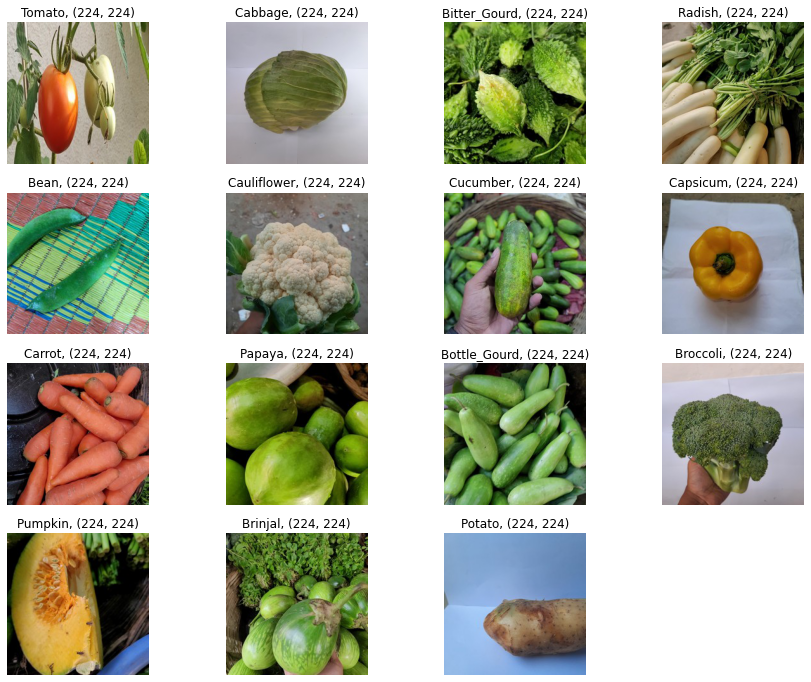

In [ ]:
## Viz Random Sample from each class
plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()): 
    # create a subplot axis
    ax = plt.subplot(4, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title 
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

In [ ]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

Count of training samples per class:
            class  count
0        Cabbage   1000
1   Bottle_Gourd   1000
2       Capsicum   1000
3           Bean   1000
4   Bitter_Gourd   1000
5        Pumpkin   1000
6         Papaya   1000
7         Radish   1000
8        Brinjal   1000
9         Potato   1000
10      Broccoli   1000
11      Cucumber   1000
12        Tomato   1000
13        Carrot   1000
14   Cauliflower   1000


<Figure size 1080x864 with 0 Axes>

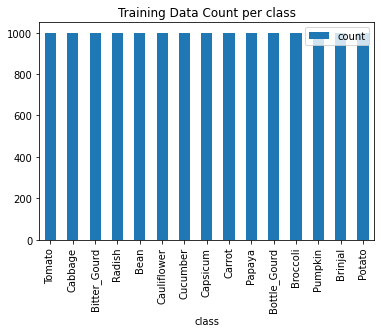

In [ ]:
# draw a bar plot using pandas in-built plotting function
plt.figure(figsize=(15,12))
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class") 
plt.show()

# Loading data set

In [ ]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    "Vegetable Images/train", shuffle = True,
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    "Vegetable Images/validation", shuffle = False,
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    "Vegetable Images/test", shuffle = False,
)


Loading Train Data...
Found 15000 files belonging to 15 classes.

Loading Validation Data...
Found 3000 files belonging to 15 classes.

Loading Test Data...
Found 3000 files belonging to 15 classes.


# Data Preprocessing

In [ ]:
height, width = 224, 224

# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(height, width), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

In [ ]:
num_classes = 15
hidden_size_1 = 1024
hidden_size_2 = 256

# VGG16

In [ ]:
pretrained_vgg16_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[height,width, 3])
pretrained_vgg16_model.trainable=False
vgg16_model = tf.keras.Sequential([
    pretrained_vgg16_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(15, activation='softmax')
])

In [ ]:
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 15)                975       
                                                                 
Total params: 14,748,495
Trainable params: 33,807
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
vgg16_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

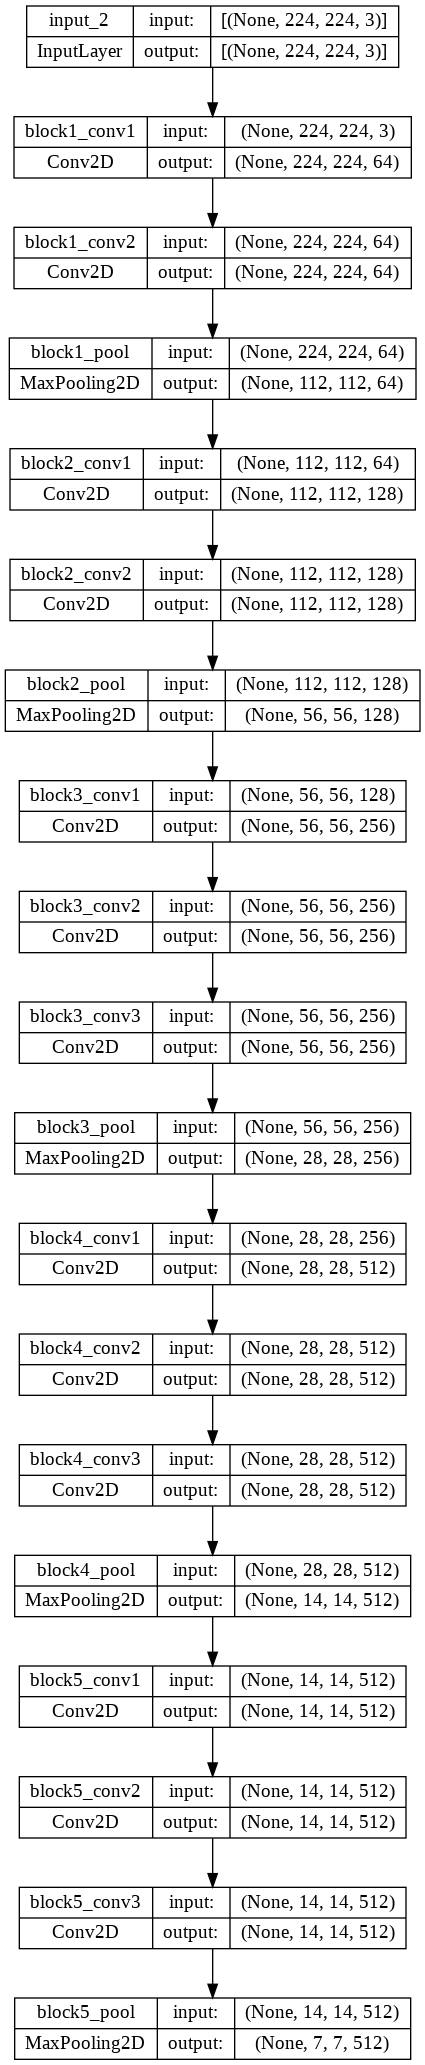

In [ ]:
tf.keras.utils.plot_model(pretrained_vgg16_model, to_file="pretrained_vgg16_model.png", show_shapes=True)

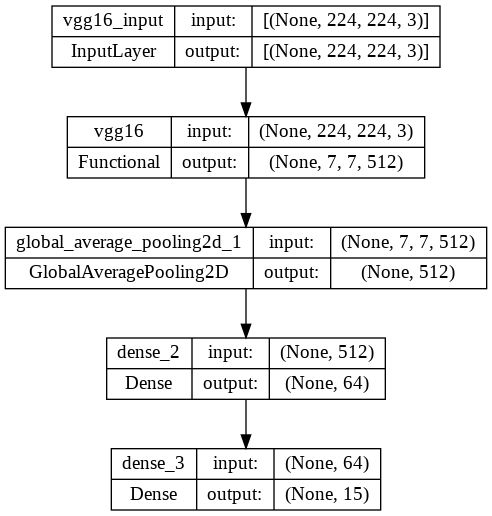

In [ ]:
tf.keras.utils.plot_model(vgg16_model, to_file="vgg16_model.png", show_shapes=True)

In [ ]:
history_vgg16 = vgg16_model.fit(train_ds, epochs=50, validation_data=val_ds,callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/50
469/469 [==============================] - 101s 191ms/step - loss: 1.1662 - accuracy: 0.7409 - val_loss: 0.5110 - val_accuracy: 0.8900
Epoch 2/50
469/469 [==============================] - 94s 199ms/step - loss: 0.3658 - accuracy: 0.9230 - val_loss: 0.2702 - val_accuracy: 0.9410
Epoch 3/50
469/469 [==============================] - 94s 201ms/step - loss: 0.2135 - accuracy: 0.9551 - val_loss: 0.1814 - val_accuracy: 0.9607
Epoch 4/50
469/469 [==============================] - 94s 201ms/step - loss: 0.1469 - accuracy: 0.9710 - val_loss: 0.1346 - val_accuracy: 0.9723
Epoch 5/50
469/469 [==============================] - 95s 201ms/step - loss: 0.1113 - accuracy: 0.9766 - val_loss: 0.1090 - val_accuracy: 0.9767
Epoch 6/50
469/469 [==============================] - 94s 201ms/step - loss: 0.0871 - accuracy: 0.9823 - val_loss: 0.0916 - val_accuracy: 0.9823
Epoch 7/50
469/469 [==============================] - 94s 200ms/step - loss: 0.0703 - accuracy: 0.9870 - val_loss: 0.0761 - val_a

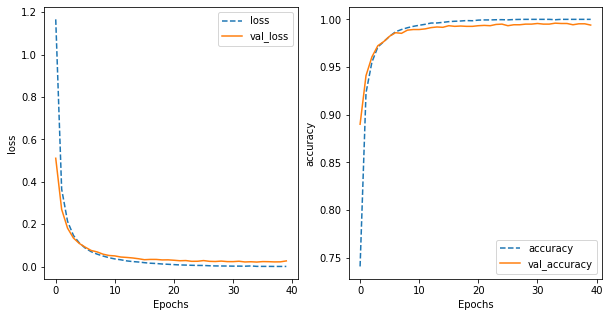

In [ ]:
training_plot(['loss', 'accuracy'], history_vgg16)

In [ ]:
testAccuracy(vgg16_model)

94/94 [==============================] - 15s 163ms/step

Test Accuracy: 99.47%



94/94 [==============================] - 16s 171ms/step


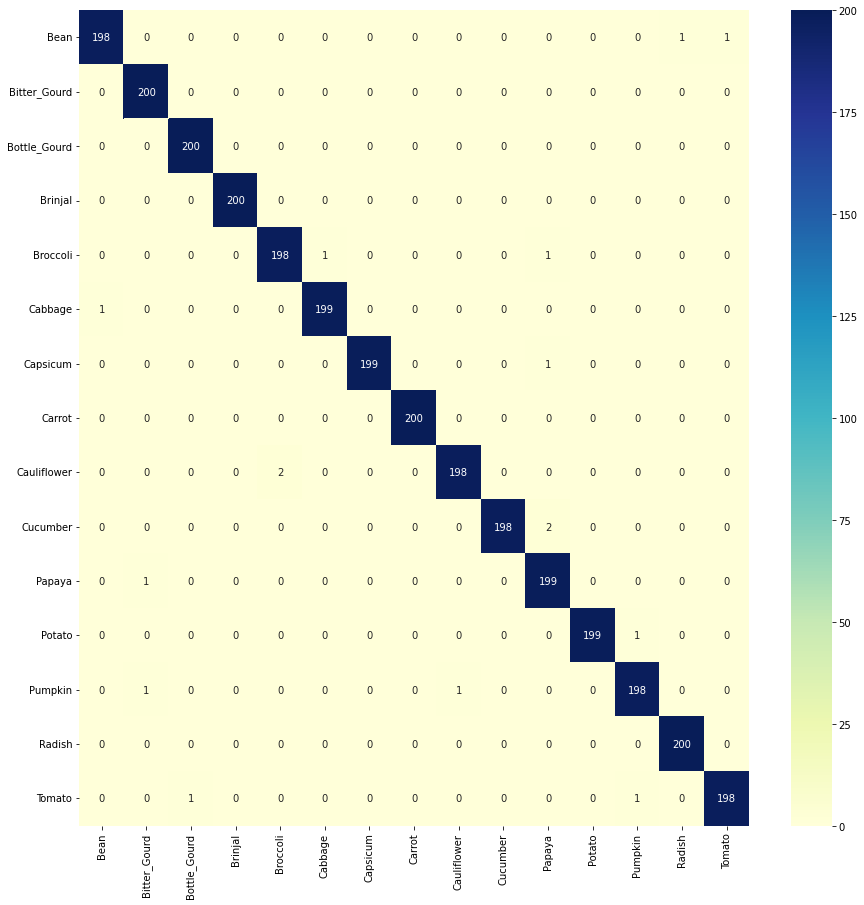

Classification Report:
----------------------
               precision    recall  f1-score   support

           0     0.9950    0.9900    0.9925       200
           1     0.9901    1.0000    0.9950       200
           2     0.9950    1.0000    0.9975       200
           3     1.0000    1.0000    1.0000       200
           4     0.9900    0.9900    0.9900       200
           5     0.9950    0.9950    0.9950       200
           6     1.0000    0.9950    0.9975       200
           7     1.0000    1.0000    1.0000       200
           8     0.9950    0.9900    0.9925       200
           9     1.0000    0.9900    0.9950       200
          10     0.9803    0.9950    0.9876       200
          11     1.0000    0.9950    0.9975       200
          12     0.9900    0.9900    0.9900       200
          13     0.9950    1.0000    0.9975       200
          14     0.9950    0.9900    0.9925       200

    accuracy                         0.9947      3000
   macro avg     0.9947    0.9947

In [ ]:
ConfusionMatrix(vgg16_model, test_ds, test_data.class_names)

## Save model

In [ ]:
vgg16_model.save('vgg16_model.h5') #tolong download file ini

# Resnet

In [ ]:
pretrained_resnet_model = tf.keras.applications.ResNet50V2(weights='imagenet',
                         include_top=False,
                         input_tensor = (tf.keras.layers.Input(shape=(height,width,3)))
                         )
pretrained_resnet_model.trainable=False
resnet_model = tf.keras.Sequential([
    pretrained_resnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(15, activation='softmax')
])

94668760/94668760 [==============================] - 4s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 15)                30735     
                                                                 
Total params: 23,595,535
Trainable params: 30,735
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

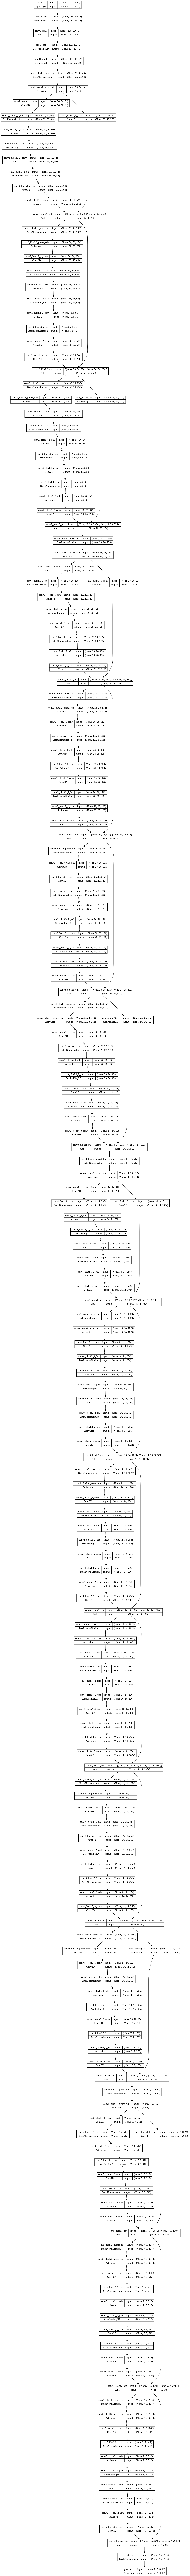

In [ ]:
tf.keras.utils.plot_model(pretrained_resnet_model, to_file="pretrained_resnet_model.png", show_shapes=True)

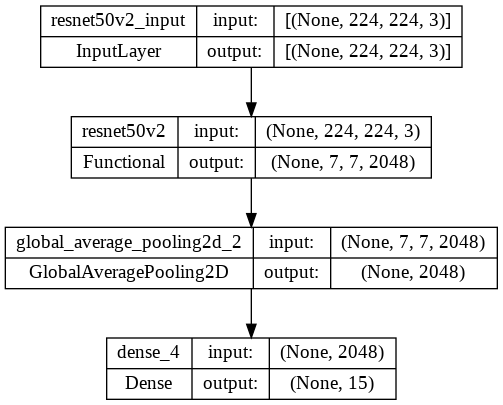

In [ ]:
tf.keras.utils.plot_model(resnet_model, to_file="resnet_model.png", show_shapes=True)

In [ ]:
history_resnet = resnet_model.fit(train_ds, epochs=25, validation_data=val_ds, callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/25
469/469 [==============================] - 59s 116ms/step - loss: 0.1646 - accuracy: 0.9617 - val_loss: 0.0321 - val_accuracy: 0.9947
Epoch 2/25
469/469 [==============================] - 54s 115ms/step - loss: 0.0180 - accuracy: 0.9972 - val_loss: 0.0164 - val_accuracy: 0.9967
Epoch 3/25
469/469 [==============================] - 54s 115ms/step - loss: 0.0082 - accuracy: 0.9993 - val_loss: 0.0130 - val_accuracy: 0.9967
Epoch 4/25
469/469 [==============================] - 55s 117ms/step - loss: 0.0046 - accuracy: 0.9997 - val_loss: 0.0113 - val_accuracy: 0.9970
Epoch 5/25
469/469 [==============================] - 54s 114ms/step - loss: 0.0030 - accuracy: 0.9999 - val_loss: 0.0102 - val_accuracy: 0.9973
Epoch 6/25
469/469 [==============================] - 54s 115ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 0.9973
Epoch 7/25
469/469 [==============================] - 54s 115ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0093 - val_ac

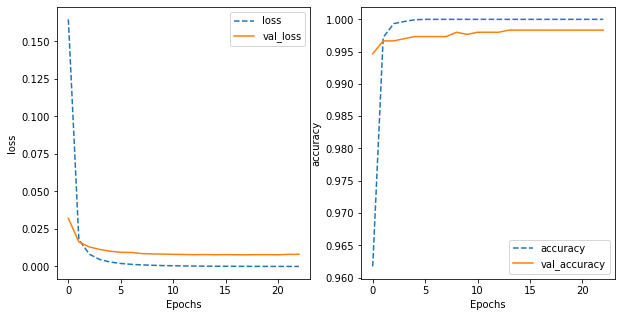

In [ ]:
training_plot(['loss', 'accuracy'], history_resnet)

In [ ]:
testAccuracy(resnet_model)

94/94 [==============================] - 9s 87ms/step

Test Accuracy: 99.73%



94/94 [==============================] - 8s 88ms/step


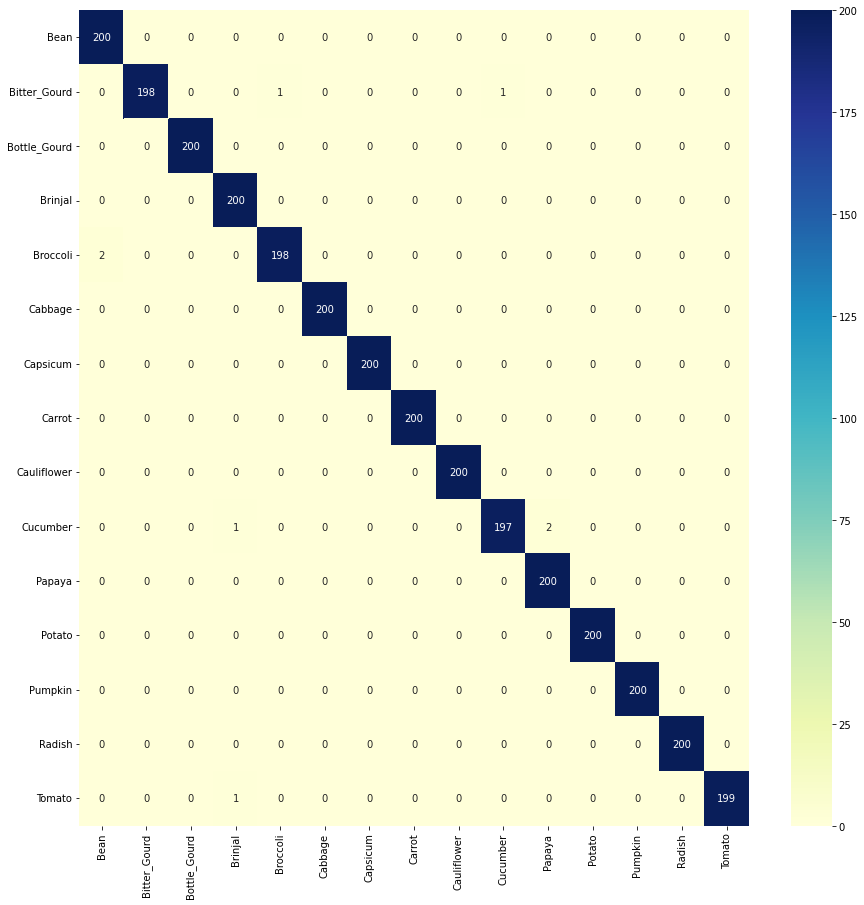

Classification Report:
----------------------
               precision    recall  f1-score   support

           0     0.9901    1.0000    0.9950       200
           1     1.0000    0.9900    0.9950       200
           2     1.0000    1.0000    1.0000       200
           3     0.9901    1.0000    0.9950       200
           4     0.9950    0.9900    0.9925       200
           5     1.0000    1.0000    1.0000       200
           6     1.0000    1.0000    1.0000       200
           7     1.0000    1.0000    1.0000       200
           8     1.0000    1.0000    1.0000       200
           9     0.9949    0.9850    0.9899       200
          10     0.9901    1.0000    0.9950       200
          11     1.0000    1.0000    1.0000       200
          12     1.0000    1.0000    1.0000       200
          13     1.0000    1.0000    1.0000       200
          14     1.0000    0.9950    0.9975       200

    accuracy                         0.9973      3000
   macro avg     0.9973    0.9973

In [ ]:
ConfusionMatrix(resnet_model, test_ds, test_data.class_names)

## Save model

In [ ]:
resnet_model.save('resnet_model.h5') #tolong download file ini

# MobileNet

In [ ]:
pretrained_mobilenet_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=[height,width, 3])
pretrained_mobilenet_model.trainable=False
mobilenet_model = tf.keras.Sequential([
    pretrained_mobilenet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(15, activation='softmax')
])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
mobilenet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
mobilenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 15)                19215     
                                                                 
Total params: 2,277,199
Trainable params: 19,215
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
history_mobilenet = mobilenet_model.fit(train_ds, epochs=15, validation_data=val_ds, callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/15
469/469 [==============================] - 46s 92ms/step - loss: 0.2139 - accuracy: 0.9525 - val_loss: 0.0395 - val_accuracy: 0.9920
Epoch 2/15
469/469 [==============================] - 38s 80ms/step - loss: 0.0256 - accuracy: 0.9971 - val_loss: 0.0204 - val_accuracy: 0.9963
Epoch 3/15
469/469 [==============================] - 39s 82ms/step - loss: 0.0126 - accuracy: 0.9989 - val_loss: 0.0148 - val_accuracy: 0.9967
Epoch 4/15
469/469 [==============================] - 42s 89ms/step - loss: 0.0074 - accuracy: 0.9995 - val_loss: 0.0115 - val_accuracy: 0.9977
Epoch 5/15
469/469 [==============================] - 38s 80ms/step - loss: 0.0047 - accuracy: 0.9999 - val_loss: 0.0097 - val_accuracy: 0.9973
Epoch 6/15
469/469 [==============================] - 38s 79ms/step - loss: 0.0033 - accuracy: 0.9999 - val_loss: 0.0086 - val_accuracy: 0.9977
Epoch 7/15
469/469 [==============================] - 37s 79ms/step - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.0080 - val_accuracy:

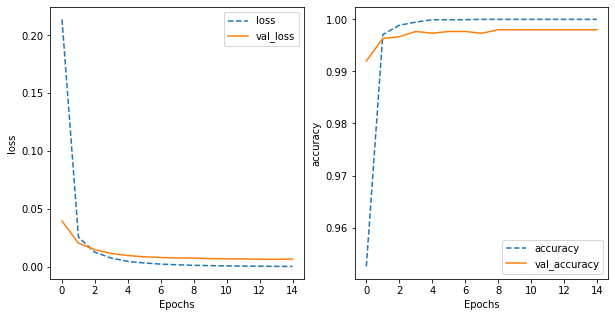

In [ ]:
training_plot(['loss', 'accuracy'], history_mobilenet)

In [ ]:
testAccuracy(mobilenet_model)

94/94 [==============================] - 7s 67ms/step

Test Accuracy: 99.93%



94/94 [==============================] - 6s 67ms/step


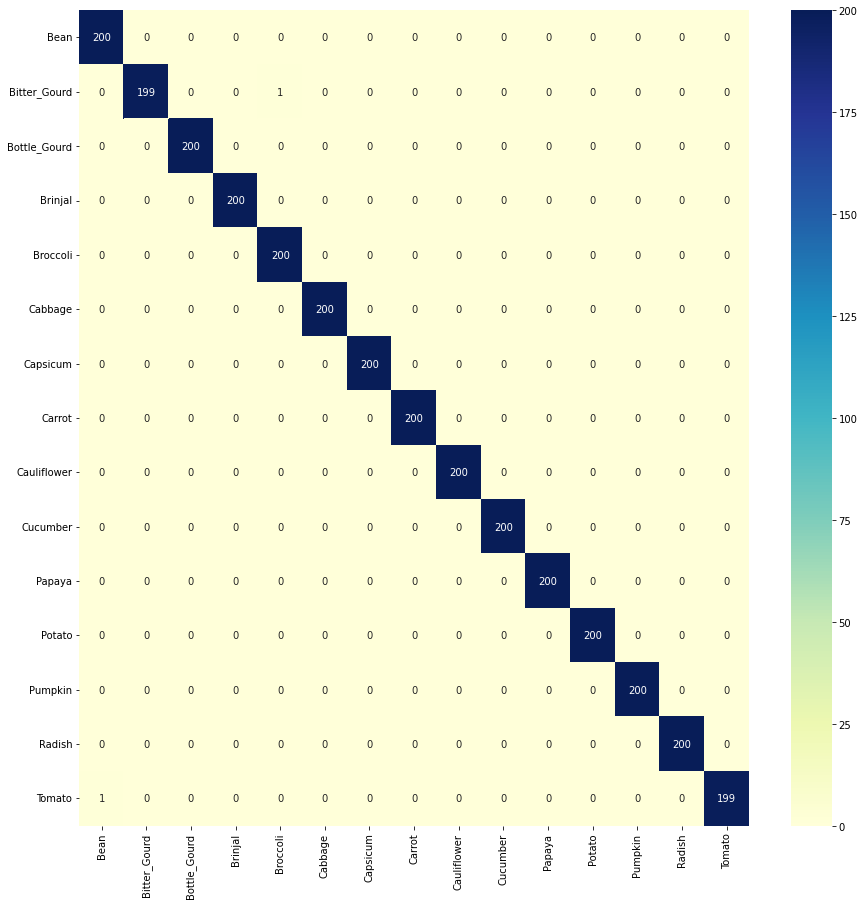

Classification Report:
----------------------
               precision    recall  f1-score   support

           0     0.9950    1.0000    0.9975       200
           1     1.0000    0.9950    0.9975       200
           2     1.0000    1.0000    1.0000       200
           3     1.0000    1.0000    1.0000       200
           4     0.9950    1.0000    0.9975       200
           5     1.0000    1.0000    1.0000       200
           6     1.0000    1.0000    1.0000       200
           7     1.0000    1.0000    1.0000       200
           8     1.0000    1.0000    1.0000       200
           9     1.0000    1.0000    1.0000       200
          10     1.0000    1.0000    1.0000       200
          11     1.0000    1.0000    1.0000       200
          12     1.0000    1.0000    1.0000       200
          13     1.0000    1.0000    1.0000       200
          14     1.0000    0.9950    0.9975       200

    accuracy                         0.9993      3000
   macro avg     0.9993    0.9993

In [ ]:
ConfusionMatrix(mobilenet_model, test_ds, test_data.class_names)

## Save model

In [ ]:
mobilenet_model.save('mobilenet_model.h5') #tolong download file ini

# Checking Predictions with the best models
- ResNet
- MobileNet

94/94 [==============================] - 8s 89ms/step


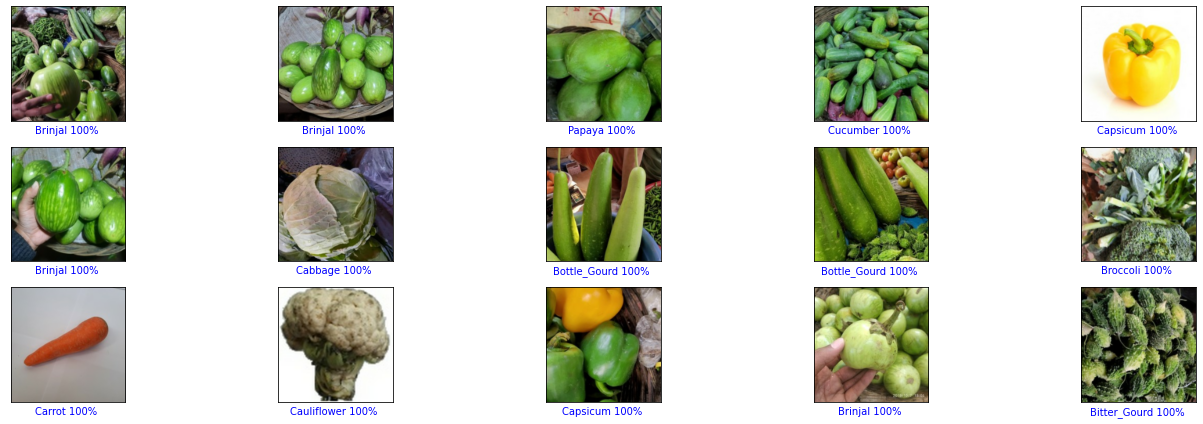

In [ ]:
predictions(resnet_model)

94/94 [==============================] - 6s 68ms/step


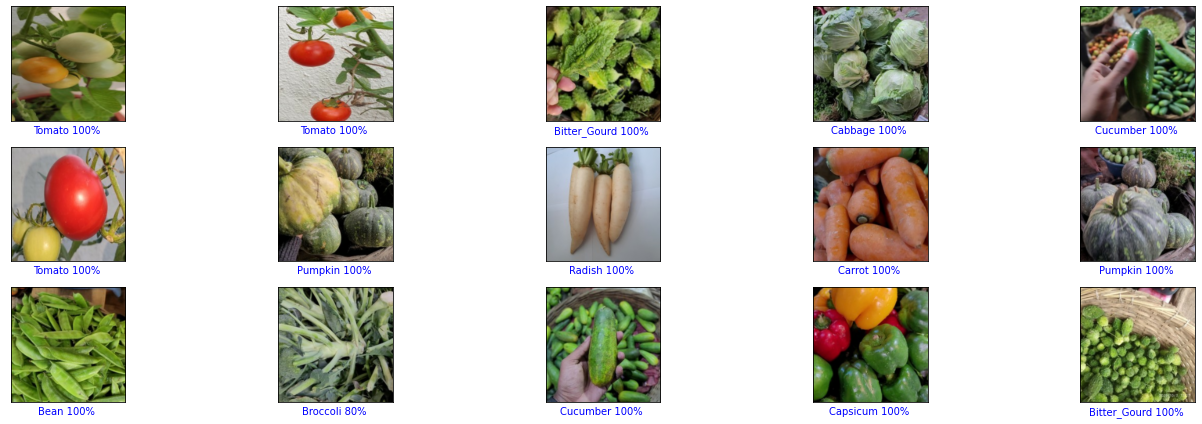

In [ ]:
predictions(mobilenet_model)

# Summary
<ul>
  <li>Simple MLP: Being a simple ANN the model is misclassifying the 'Cucumber','Papaya' and 'Cauliflower' and gives a test accuracy of around 75%.</li>
  <li>Baseline Model: The model itself is performing really well with the data set and giving 74% test accuracy.</li>
  <li>Improved Baseline Model: By adding more depth to the model and adding Batchnormalization and Dropout layers with early stopping the model exceptionally well with test accuracy above 90%. </li>
  <li>Transfer Learning: All the models performed really well and test accuracy was exceptionally amazing with simple architecture like Mobilenet and surprisingly well with the naive model like VGG16.</li>
</ul>
